# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving MSFT_stocks_data.csv to MSFT_stocks_data (1).csv
Saving IBM_stocks_data.csv to IBM_stocks_data (1).csv
Saving GOOGL_stocks_data.csv to GOOGL_stocks_data (1).csv
Saving AMZN_stocks_data.csv to AMZN_stocks_data (1).csv


In [4]:
# Define a function to load data and aggregate them





def load_and_aggregate_data(file_paths):
    master_df = None
    for file_path in file_paths:
        stock_name = file_path.split('_')[0].upper()
        df = pd.read_csv(file_path)
        # --- FIX: Use format='mixed' and dayfirst=True to handle inconsistent date formats ---
        df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
        df = df.set_index('Date')

        if 'Name' in df.columns:
            df = df.drop(columns=['Name'])

        columns_to_prefix = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
        new_columns = {col: f"{col}_{stock_name}" for col in columns_to_prefix if col in df.columns}
        df = df.rename(columns=new_columns)

        if master_df is None:
            master_df = df
        else:
            master_df = pd.merge(master_df, df, left_index=True, right_index=True, how='outer')

    master_df = master_df.sort_index()
    return master_df

In [5]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
print("---  Data Aggregation ---")
file_names = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']
master_df = load_and_aggregate_data(file_names)


---  Data Aggregation ---


In [6]:
# Show head of the data

print("--- Data Aggregation & Initial View ---")
print("Shape of the aggregated DataFrame:", master_df.shape)
print("\nFirst 5 rows of the aggregated DataFrame:")
print(master_df.head())
print("\nInformation about the aggregated DataFrame:")
master_df.info()
print("\nDescriptive statistics of the aggregated DataFrame:")
print(master_df.describe())

--- Data Aggregation & Initial View ---
Shape of the aggregated DataFrame: (3020, 20)

First 5 rows of the aggregated DataFrame:
            Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  \
Date                                                                  
2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

            Open_GOOGL  High_GOOGL  Low_GOOGL  Close_GOOGL  Volume_GOOGL  \
Date                                                                       
2006-01-03      211.47      218.05     209.32       217.83    13137450.0   
2006-01-04      222.17      224.70     220.09       222.84    15292353.0   
2006-01-05      223.22      226.00     220.97       225.85    1081566

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [7]:
# Handle Missing Values

print("\n---  Handling Missing Values ---")
# Check for missing values
print("\nMissing values before handling:")
print(master_df.isnull().sum())


master_df.fillna(method='ffill', inplace=True)
master_df.fillna(method='bfill', inplace=True) # In case there are NaNs at the very beginning

print("\nMissing values after handling:")
print(master_df.isnull().sum())


---  Handling Missing Values ---

Missing values before handling:
Open_AMZN       1
High_AMZN       1
Low_AMZN        1
Close_AMZN      1
Volume_AMZN     1
Open_GOOGL      1
High_GOOGL      1
Low_GOOGL       1
Close_GOOGL     1
Volume_GOOGL    1
Open_IBM        1
High_IBM        0
Low_IBM         1
Close_IBM       0
Volume_IBM      0
Open_MSFT       1
High_MSFT       1
Low_MSFT        1
Close_MSFT      1
Volume_MSFT     1
dtype: int64

Missing values after handling:
Open_AMZN       0
High_AMZN       0
Low_AMZN        0
Close_AMZN      0
Volume_AMZN     0
Open_GOOGL      0
High_GOOGL      0
Low_GOOGL       0
Close_GOOGL     0
Volume_GOOGL    0
Open_IBM        0
High_IBM        0
Low_IBM         0
Close_IBM       0
Volume_IBM      0
Open_MSFT       0
High_MSFT       0
Low_MSFT        0
Close_MSFT      0
Volume_MSFT     0
dtype: int64


<ipython-input-7-c2e823c89eab>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_df.fillna(method='ffill', inplace=True)
<ipython-input-7-c2e823c89eab>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_df.fillna(method='bfill', inplace=True) # In case there are NaNs at the very beginning


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

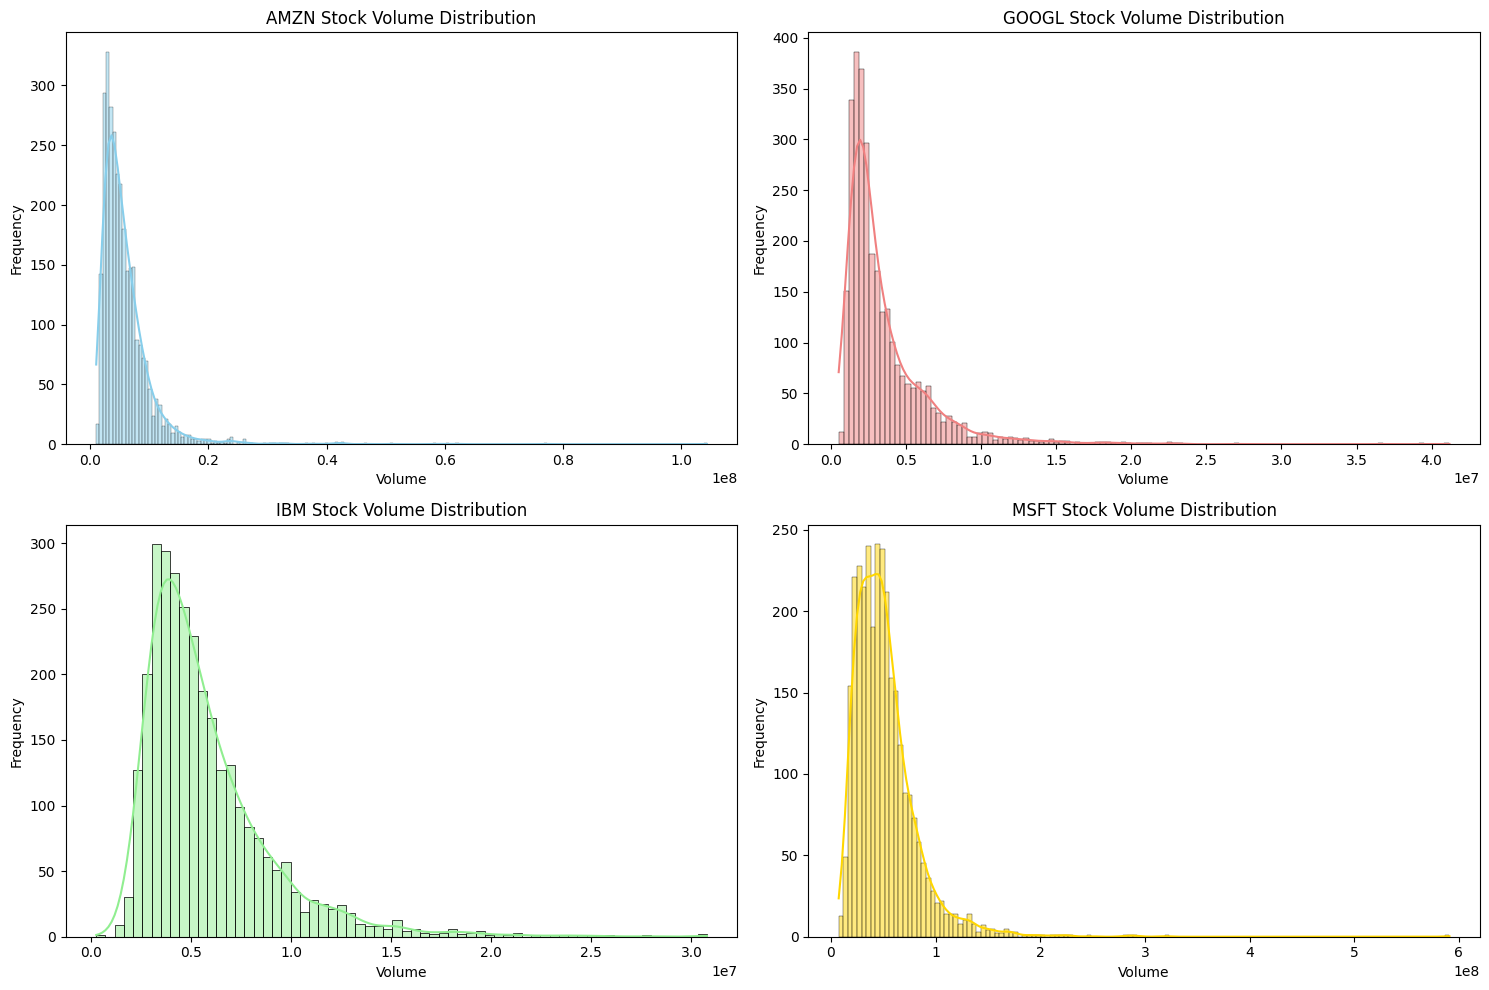

In [8]:



# Frequency distribution of volumes


# Reload individual dataframes to access 'Volume'
df_amzn = pd.read_csv('AMZN_stocks_data.csv')
df_googl = pd.read_csv('GOOGL_stocks_data.csv')
df_ibm = pd.read_csv('IBM_stocks_data.csv')
df_msft = pd.read_csv('MSFT_stocks_data.csv')

# Plotting frequency distribution of volumes for each company
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(df_amzn['Volume'], kde=True, color='skyblue')
plt.title('AMZN Stock Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(df_googl['Volume'], kde=True, color='lightcoral')
plt.title('GOOGL Stock Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(df_ibm['Volume'], kde=True, color='lightgreen')
plt.title('IBM Stock Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(df_msft['Volume'], kde=True, color='gold')
plt.title('MSFT Stock Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

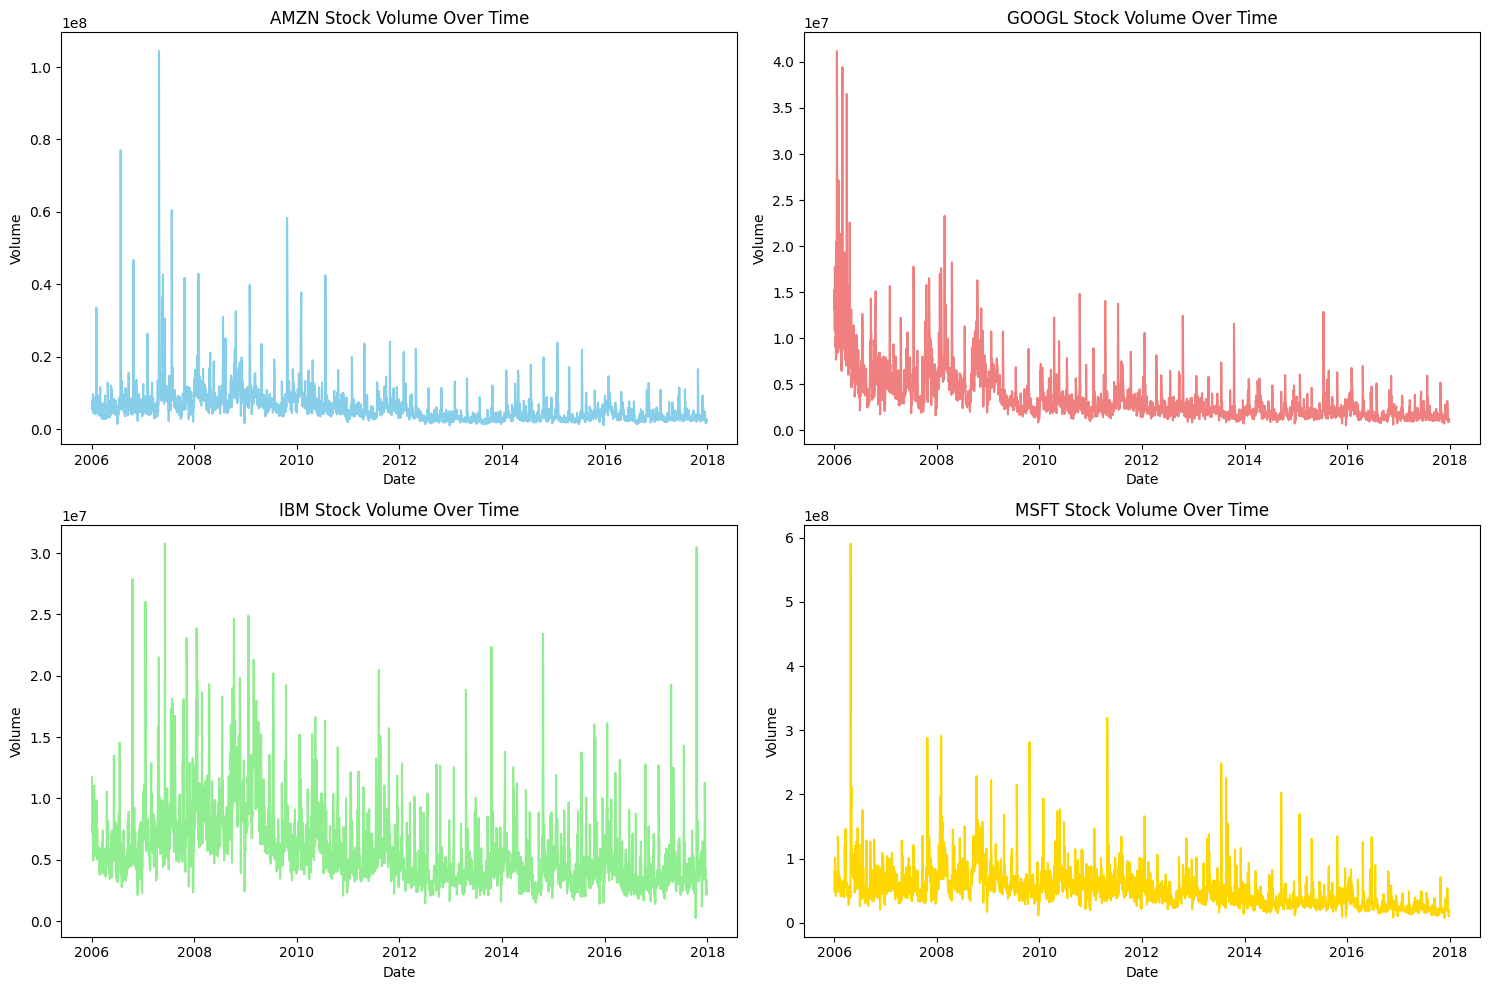

In [9]:


# Stock volume variation over time

df_amzn['Date'] = pd.to_datetime(df_amzn['Date'], format='mixed', dayfirst=True, errors='coerce')
df_googl['Date'] = pd.to_datetime(df_googl['Date'], format='mixed', dayfirst=True, errors='coerce')
df_ibm['Date'] = pd.to_datetime(df_ibm['Date'], format='mixed', dayfirst=True, errors='coerce')
df_msft['Date'] = pd.to_datetime(df_msft['Date'], format='mixed', dayfirst=True, errors='coerce')


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df_amzn['Date'], df_amzn['Volume'], color='skyblue')
plt.title('AMZN Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.subplot(2, 2, 2)
plt.plot(df_googl['Date'], df_googl['Volume'], color='lightcoral')
plt.title('GOOGL Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.subplot(2, 2, 3)
plt.plot(df_ibm['Date'], df_ibm['Volume'], color='lightgreen')
plt.title('IBM Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.subplot(2, 2, 4)
plt.plot(df_msft['Date'], df_msft['Volume'], color='gold')
plt.title('MSFT Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

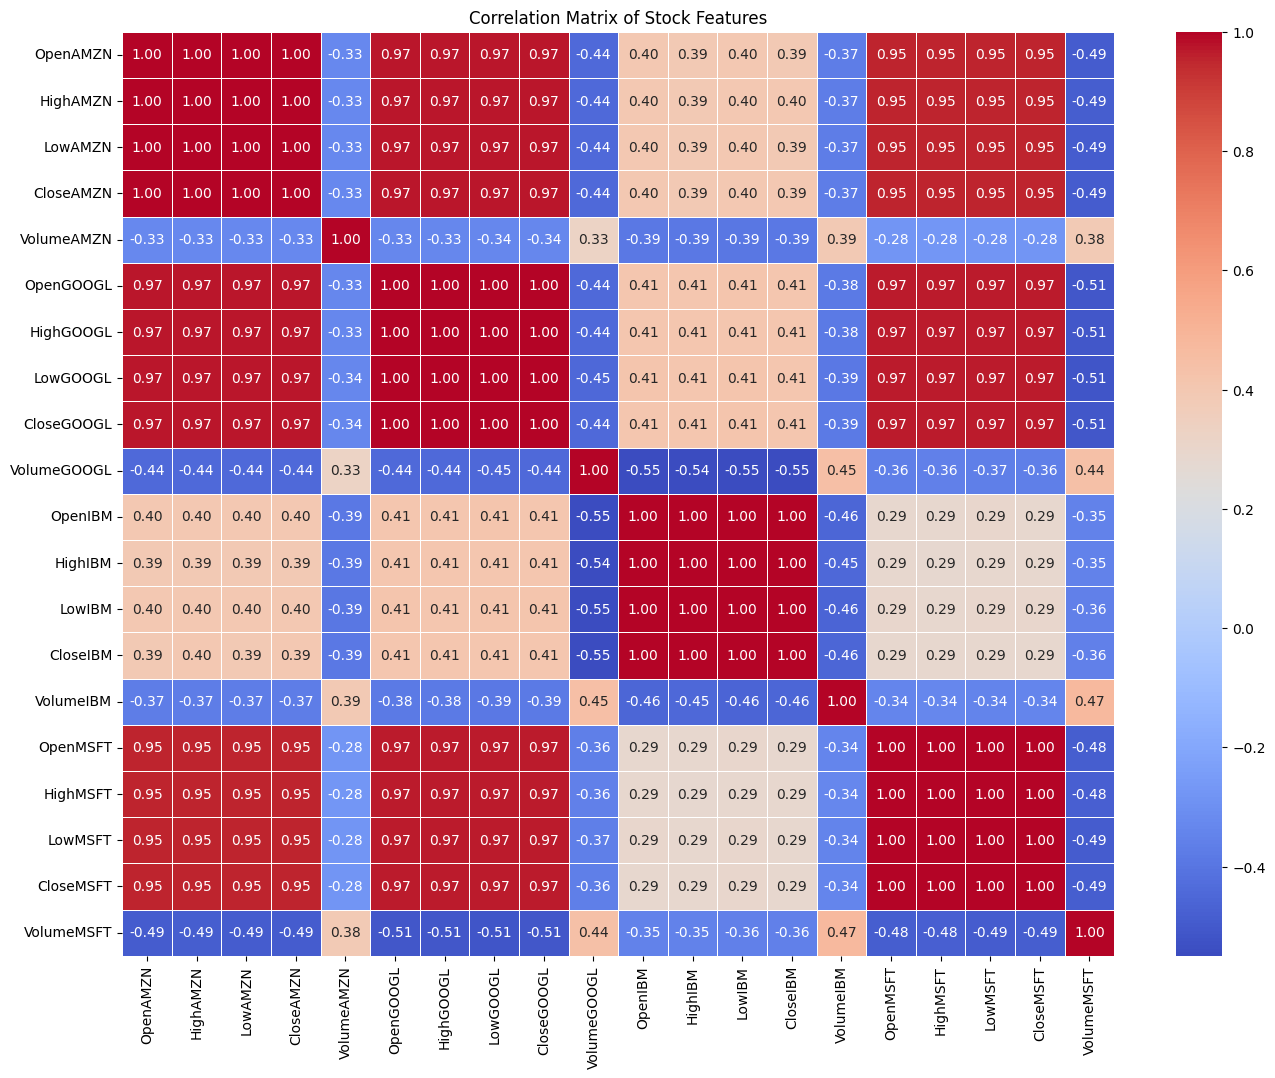

Correlation Matrix:
|             | OpenAMZN   | HighAMZN   | LowAMZN   | CloseAMZN   | VolumeAMZN   | OpenGOOGL   | HighGOOGL   | LowGOOGL   | CloseGOOGL   | VolumeGOOGL   | OpenIBM   | HighIBM   | LowIBM    | CloseIBM   | VolumeIBM   | OpenMSFT   | HighMSFT   | LowMSFT   | CloseMSFT   | VolumeMSFT   |
|:------------|:-----------|:-----------|:----------|:------------|:-------------|:------------|:------------|:-----------|:-------------|:--------------|:----------|:----------|:----------|:-----------|:------------|:-----------|:-----------|:----------|:------------|:-------------|
| OpenAMZN    | 1          | 0.999931   | 0.999896  | 0.999833    | -0.327718    | 0.97268     | 0.972537    | 0.973023   | 0.972763     | -0.440651     | 0.396641  | 0.393261  | 0.397839  | 0.394719   | -0.372124   | 0.953533   | 0.953443   | 0.953516  | 0.953541    | -0.489123    |
| HighAMZN    | 0.999931   | 1          | 0.999889  | 0.999923    | -0.325821    | 0.972805    | 0.972745    | 0.973185   | 0

In [10]:


# Analyse correlations

def load_and_merge_all_data(file_names):
    all_dfs = []
    for file_name in file_names:
        stock_name = file_name.split('_')[0]
        df = pd.read_csv(file_name)
        df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True, errors='coerce')

        df = df.rename(columns={
            'Open': f'Open{stock_name}',
            'High': f'High{stock_name}',
            'Low': f'Low{stock_name}',
            'Close': f'Close{stock_name}',
            'Volume': f'Volume{stock_name}',
            'Name': 'Name'
        })

        df = df.drop(columns=['Name'])
        all_dfs.append(df)

    if all_dfs:
        combined_df = all_dfs[0]
        for i in range(1, len(all_dfs)):
            combined_df = pd.merge(combined_df, all_dfs[i], on='Date', how='inner')
    else:
        combined_df = pd.DataFrame()
    return combined_df

full_master_df = load_and_merge_all_data(file_names)

# Sort by date
full_master_df = full_master_df.sort_values(by='Date').reset_index(drop=True)

# Select only numerical columns for correlation analysis
numerical_df = full_master_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Stock Features')
plt.show()

print("Correlation Matrix:")
print(correlation_matrix.to_markdown(numalign="left", stralign="left"))

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [11]:


# Define a function that divides the data into windows and generates target variable values for each window

def create_windows(data, window_size, window_stride, target_names):

    X_windows = []
    y_targets = []

    for target in target_names:
        if target not in data.columns:
            raise ValueError(f"Target column '{target}' not found in the data.")


    feature_columns = [col for col in data.columns if col not in target_names and col != 'Date']

    # Iterate through the data to create windows

    for i in range(0, len(data) - window_size - len(target_names) + 1, window_stride):

        X_window = data.iloc[i : i + window_size][feature_columns]

        # The target y is the 'Close' price(s) at the step immediately following the window
        y_target = data.iloc[i + window_size][target_names]

        X_windows.append(X_window.values)
        y_targets.append(y_target.values)

    return np.array(X_windows), np.array(y_targets)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [12]:
# Define a function that scales the windowed data

def scale_windowed_data(X_train_windows, X_test_windows, y_train_targets, y_test_targets):

    num_train_samples, window_size, num_features = X_train_windows.shape
    X_train_reshaped = X_train_windows.reshape(-1, num_features)

    X_scaler = MinMaxScaler()
    X_scaler.fit(X_train_reshaped)

    X_train_scaled_reshaped = X_scaler.transform(X_train_reshaped)
    X_train_scaled = X_train_scaled_reshaped.reshape(num_train_samples, window_size, num_features)

    num_test_samples = X_test_windows.shape[0]
    X_test_reshaped = X_test_windows.reshape(-1, num_features)
    X_test_scaled_reshaped = X_scaler.transform(X_test_reshaped)
    X_test_scaled = X_test_scaled_reshaped.reshape(num_test_samples, window_size, num_features)

    y_scaler = MinMaxScaler()
    y_scaler.fit(y_train_targets)

    y_train_scaled = y_scaler.transform(y_train_targets)
    y_test_scaled = y_scaler.transform(y_test_targets)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [13]:
# Define a function to create input and output data points from the master DataFrame


def create_and_split_data(data, target_names, window_size, window_stride, test_size):


    X_windows, y_targets = create_windows(data, window_size, window_stride, target_names)


    X_train, X_test, y_train, y_test = train_test_split(
        X_windows, y_targets, test_size=test_size, shuffle=False
    )


    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = \
        scale_windowed_data(X_train, X_test, y_train, y_test)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

Index(['Open_AMZN', 'High_AMZN', 'Low_AMZN', 'Close_AMZN', 'Volume_AMZN',
       'Open_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Close_GOOGL', 'Volume_GOOGL',
       'Open_IBM', 'High_IBM', 'Low_IBM', 'Close_IBM', 'Volume_IBM',
       'Open_MSFT', 'High_MSFT', 'Low_MSFT', 'Close_MSFT', 'Volume_MSFT'],
      dtype='object')

---  Identifying Appropriate Window Size ---


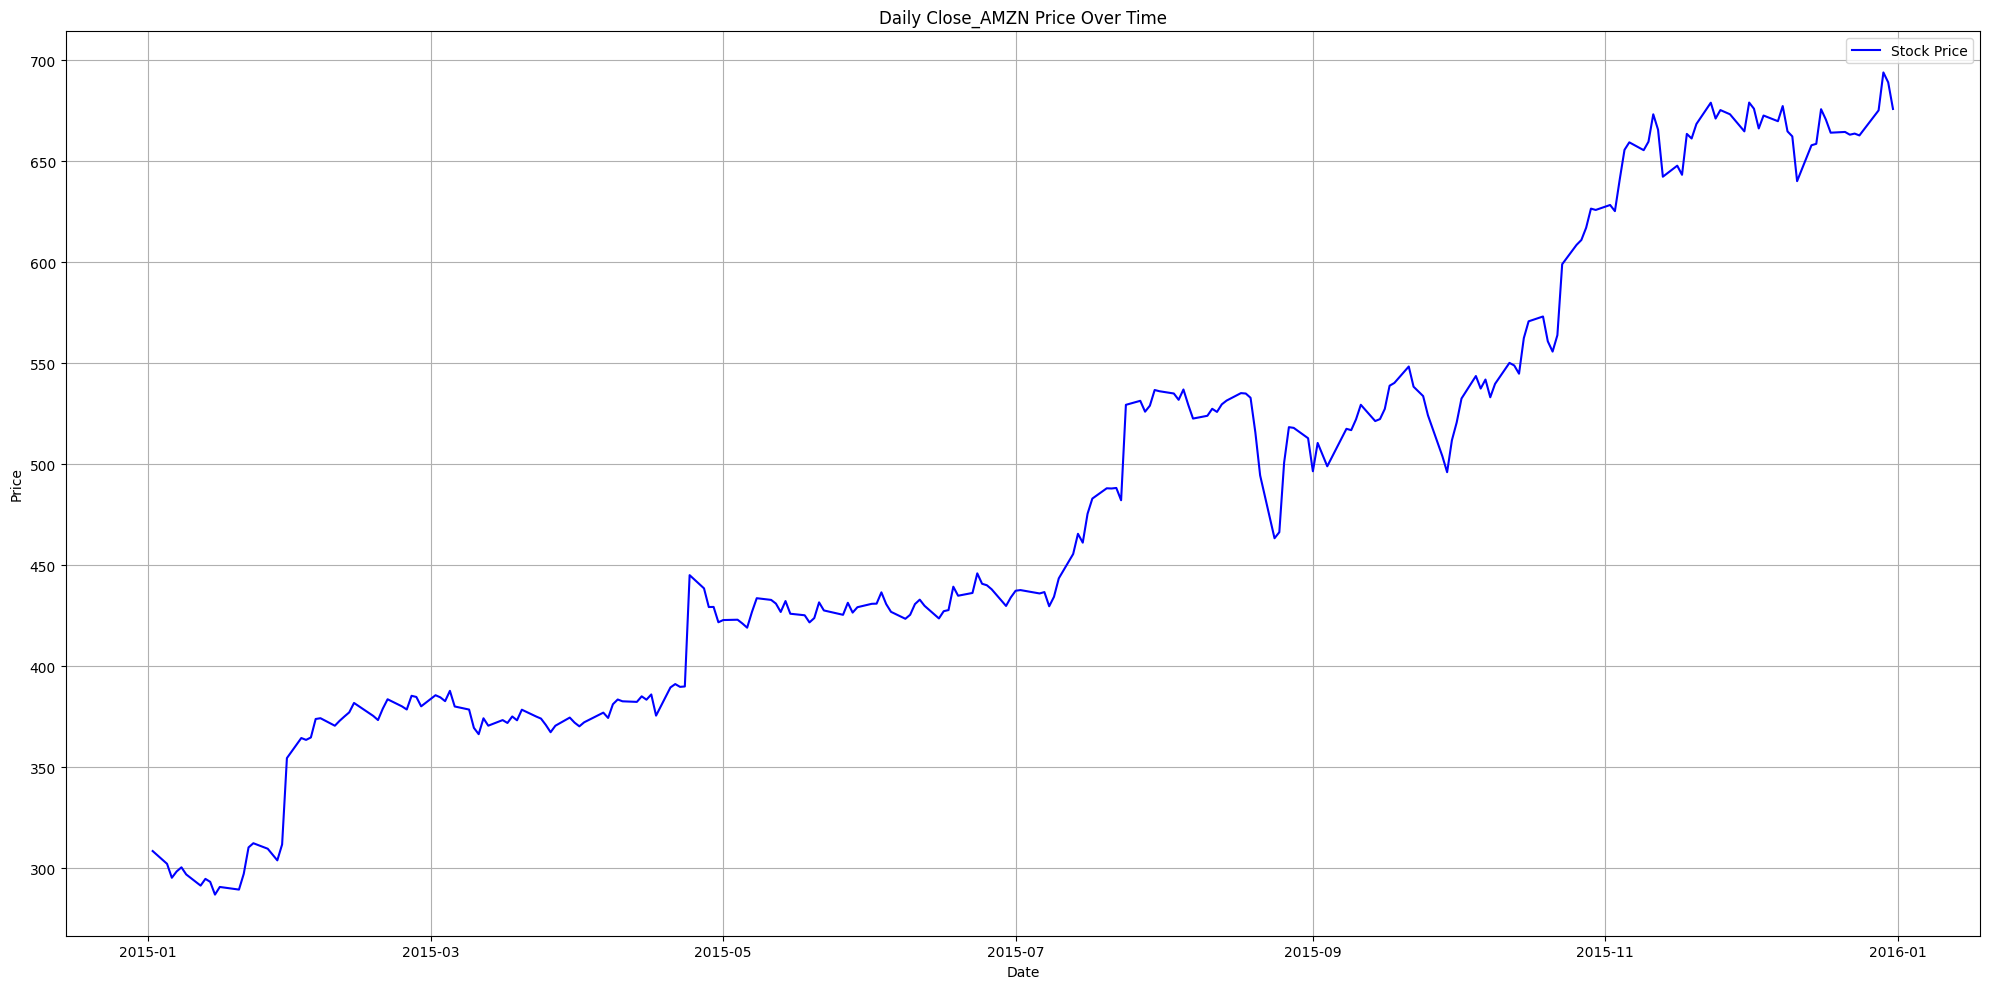


Based on typical financial analysis and the structure of daily data:
- A window size of 5 days represents a trading week.
- A window size of ~20-22 days represents a trading month.
- A window size of ~63-65 days represents a trading quarter.
The problem statement also hints at using a window size of 65 for multiple target prediction (Optional section).

Decided Window Size: 65
Decided Window Stride: 1
Decided Test Split Ratio: 0.2


In [14]:
# Checking for patterns in different sequence lengths
print(master_df.columns)

# Ensure 'Date' is a column, not the index
if master_df.index.name == 'Date':
    master_df.reset_index(inplace=True)

# Convert to datetime safely
if 'Date' in master_df.columns:
    master_df['Date'] = pd.to_datetime(master_df['Date'], dayfirst=True, errors='coerce')
else:
    raise KeyError("The 'Date' column is missing from master_df.")

sample_stock = 'Close_AMZN'
start_date = '2015-01-01'
end_date = '2016-01-01'

print("\n---  Identifying Appropriate Window Size ---")

# Check that the column exists
if sample_stock in master_df.columns:
    # Ensure 'Date' column is datetime type
    master_df['Date'] = pd.to_datetime(master_df['Date'])

    # Filter by date range and set index to Date
    filtered_df = master_df[(master_df['Date'] >= start_date) & (master_df['Date'] <= end_date)].copy()
    filtered_df.set_index('Date', inplace=True)

    # Plotting
    plt.figure(figsize=(20, 10))
    plt.plot(filtered_df.index, filtered_df[sample_stock], label='Stock Price', color='blue')
    plt.title(f'Daily {sample_stock} Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"'{sample_stock}' not found in master_df columns. Please ensure 1.1 Data Aggregation was run successfully.")

# Print final decision
print("\nBased on typical financial analysis and the structure of daily data:")
print("- A window size of 5 days represents a trading week.")
print("- A window size of ~20-22 days represents a trading month.")
print("- A window size of ~63-65 days represents a trading quarter.")
print("The problem statement also hints at using a window size of 65 for multiple target prediction (Optional section).")

# Final decision
window_size = 65
window_stride = 1
test_split_ratio = 0.2

print(f"\nDecided Window Size: {window_size}")
print(f"Decided Window Stride: {window_stride}")
print(f"Decided Test Split Ratio: {test_split_ratio}")


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [15]:
# Create data instances from the master data frame using decided window size and window stride

print("\n---  Creating Data Instances from Master DataFrame ---")


target_names = [col for col in master_df.columns if 'Close' in col]
print(f"Target variables for prediction: {target_names}")


X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = \
    create_and_split_data(master_df, target_names, window_size, window_stride, test_split_ratio)

# Check the number of data points generated and their shapes
print("\n--- Check the number of data points generated ---")
print(f"Shape of X_train (scaled): {X_train_scaled.shape}")
print(f"Shape of y_train (scaled): {y_train_scaled.shape}")
print(f"Shape of X_test (scaled): {X_test_scaled.shape}")
print(f"Shape of y_test (scaled): {y_test_scaled.shape}")

print("\n--- Check if the datasets are compatible inputs to neural networks ---")
if len(X_train_scaled.shape) == 3 and X_train_scaled.shape[1] == window_size:
    print(f"X_train_scaled shape ({X_train_scaled.shape}) is compatible with RNN input (samples, timesteps, features).")
else:
    print(f"X_train_scaled shape ({X_train_scaled.shape}) is NOT compatible with RNN input (samples, timesteps, features). Expected timesteps to be {window_size}.")

if len(y_train_scaled.shape) == 2 and y_train_scaled.shape[1] == len(target_names):
    print(f"y_train_scaled shape ({y_train_scaled.shape}) is compatible with RNN output (samples, targets).")
else:
    print(f"y_train_scaled shape ({y_train_scaled.shape}) is NOT compatible with RNN output (samples, targets). Expected number of targets to be {len(target_names)}.")

print("\nData preprocessing complete. The data is now ready for RNN model building.")


---  Creating Data Instances from Master DataFrame ---
Target variables for prediction: ['Close_AMZN', 'Close_GOOGL', 'Close_IBM', 'Close_MSFT']

--- Check the number of data points generated ---
Shape of X_train (scaled): (2361, 65, 16)
Shape of y_train (scaled): (2361, 4)
Shape of X_test (scaled): (591, 65, 16)
Shape of y_test (scaled): (591, 4)

--- Check if the datasets are compatible inputs to neural networks ---
X_train_scaled shape ((2361, 65, 16)) is compatible with RNN input (samples, timesteps, features).
y_train_scaled shape ((2361, 4)) is compatible with RNN output (samples, targets).

Data preprocessing complete. The data is now ready for RNN model building.


In [16]:
# Check the number of data points generated


print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_test_scaled shape: {y_test_scaled.shape}")

X_train_scaled shape: (2361, 65, 16)
y_train_scaled shape: (2361, 4)
X_test_scaled shape: (591, 65, 16)
y_test_scaled shape: (591, 4)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [17]:
# Check if the datasets are compatible inputs to neural networks


print("Checking for NaN values:")
print(f"NaNs in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"NaNs in y_train_scaled: {np.isnan(y_train_scaled).sum()}")
print(f"NaNs in X_test_scaled: {np.isnan(X_test_scaled).sum()}")
print(f"NaNs in y_test_scaled: {np.isnan(y_test_scaled).sum()}")

print("\nChecking for infinite values:")
print(f"Infs in X_train_scaled: {np.isinf(X_train_scaled).sum()}")
print(f"Infs in y_train_scaled: {np.isinf(y_train_scaled).sum()}")
print(f"Infs in X_test_scaled: {np.isinf(X_test_scaled).sum()}")
print(f"Infs in y_test_scaled: {np.isinf(y_test_scaled).sum()}")

# Ensure data types are float32 for Keras compatibility
X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)
y_train_scaled = y_train_scaled.astype(np.float32)
y_test_scaled = y_test_scaled.astype(np.float32)

print("\nData types after conversion:")
print(f"X_train_scaled dtype: {X_train_scaled.dtype}")
print(f"y_train_scaled dtype: {y_train_scaled.dtype}")

Checking for NaN values:
NaNs in X_train_scaled: 0
NaNs in y_train_scaled: 0
NaNs in X_test_scaled: 0
NaNs in y_test_scaled: 0

Checking for infinite values:
Infs in X_train_scaled: 0
Infs in y_train_scaled: 0
Infs in X_test_scaled: 0
Infs in y_test_scaled: 0

Data types after conversion:
X_train_scaled dtype: float32
y_train_scaled dtype: float32


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [18]:
# Create a function that creates a simple RNN model according to the model configuration arguments


def create_simple_rnn_model(input_shape, output_units, rnn_units=50, dense_units=25,
                            dropout_rate=0.2, learning_rate=0.001):

    model = Sequential([

        SimpleRNN(units=rnn_units, input_shape=input_shape, activation='relu', return_sequences=False),
        Dropout(dropout_rate),
        Dense(units=dense_units, activation='relu'),
        Dense(units=output_units)
    ])


    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae', 'mse'])

    return model

print("Function 'create_simple_rnn_model' defined successfully with default hyperparameters.")

Function 'create_simple_rnn_model' defined successfully with default hyperparameters.


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [19]:
# Find an optimal configuration of simple RNN

rnn_units = 50
dense_units = 25
dropout_rate = 0.2
learning_rate = 0.001

# Training parameters
epochs = 100
batch_size = 32
patience = 8 # Early stopping patience


if 'X_train_scaled' in locals() and 'y_train_scaled' in locals():
    input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
    output_units = y_train_scaled.shape[1]
    print(f"RNN Input Shape: {input_shape}")
    print(f"RNN Output Units: {output_units}")
else:
    print("Error: X_train_scaled or y_train_scaled not found. Please run data preparation steps (1.1 - 1.3.5) first.")

    exit()

# Create the Simple RNN model
simple_rnn_model = create_simple_rnn_model(
    input_shape=input_shape,
    output_units=output_units,
    rnn_units=rnn_units,
    dense_units=dense_units,
    dropout_rate=dropout_rate,
    learning_rate=learning_rate
)

print("\n--- Simple RNN Model Summary ---")
simple_rnn_model.summary()

# Define EarlyStopping callback
early_stopping_simple_rnn = EarlyStopping(
    monitor='val_mae',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

print("\n--- Training Simple RNN Model ---")
# Train the model
history_simple_rnn = simple_rnn_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stopping_simple_rnn],
    verbose=2
)

print("\nSimple RNN model training complete.")

RNN Input Shape: (65, 16)
RNN Output Units: 4

--- Simple RNN Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         3,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,729 (18.47 KB)

 Trainable params: 4,729 (18.47 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Simple RNN Model ---
Epoch 1/100
74/74 - 4s - 56ms/step - loss: 0.0442 - mae: 0.1416 - mse: 0.0442 - val_loss: 0.2019 - val_mae: 0.3632 - val_mse: 0.2019
Epoch 2/100
74/74 - 2s - 28ms/step - loss: 0.0091 - mae: 0.0697 - mse: 0.0091 - val_loss: 0.1035 - val_mae: 0.2608 - val_mse: 0.1035
Epoch 3/100
74/74 - 1s - 14ms/step - loss: 0.0059 - mae: 0.0562 - mse: 0.0059 - val_loss: 0.0562 - val_mae: 0.1906 - val_mse: 0.0562
Epoch 4/100
74/74 - 1s - 18ms/step - loss: 0.0047 - mae: 0.0500 - mse: 0.0047 - val_loss: 0.0616 - val_mae: 0.1997 - val_mse: 0.0616
Epoch 5/100
74/74 - 2s - 24ms/step - loss: 0.0038 - mae: 0.0452 - mse: 0.0038 - val_loss: 0.0565 - val_mae: 0.1968 - val_mse: 0.0565
Epoch 6/100
74/74 - 2s - 25ms/step - loss: 0.0036 - mae: 0.0432 - mse: 0.0036 - val_loss: 0.0418 - val_mae: 0.1544 - val_mse: 0.0418
Epoch 7/100
74/74 - 1s - 15ms/step - loss: 0.0031 - mae: 0.0407 - mse: 0.0031 - val_loss: 0.0482 - val_mae: 0.1604 - val_mse: 0.0482
Epoch 8/100
74/74 - 1s - 17ms/step

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

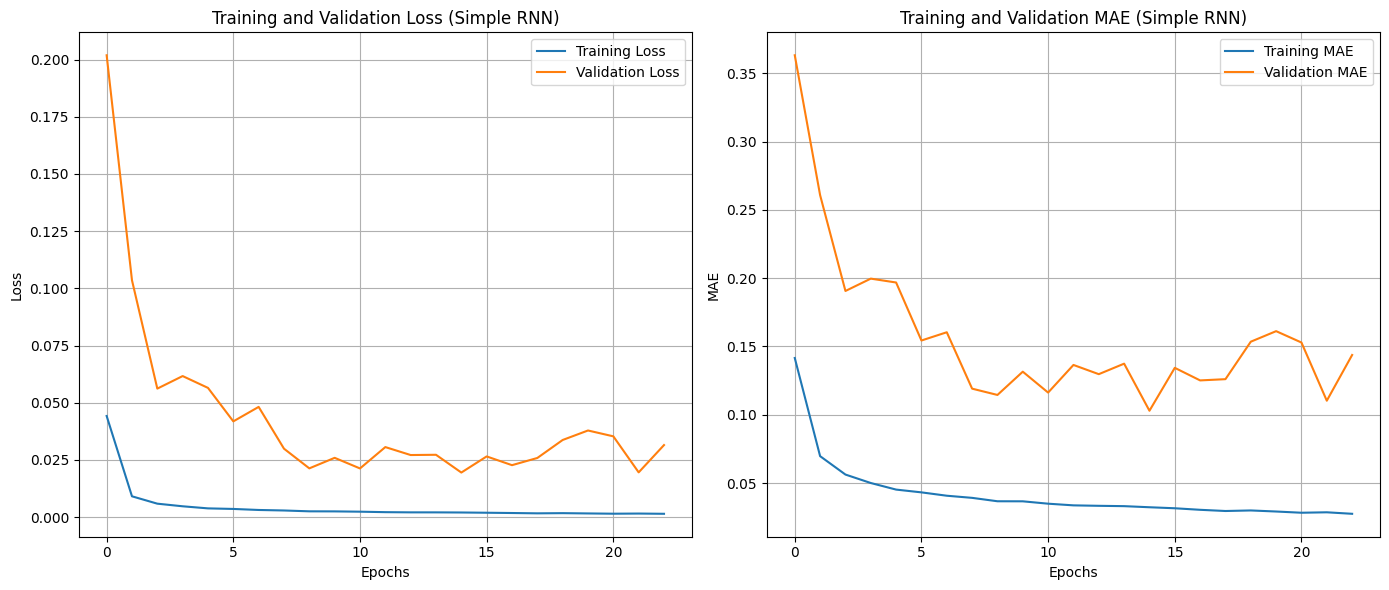

In [20]:
# Check if history_simple_rnn and simple_rnn_model are defined





if 'history_simple_rnn' not in locals() or 'simple_rnn_model' not in locals():
    print("Error: 'history_simple_rnn' or 'simple_rnn_model' not found. Please run section 2.1.2 to train the model first.")
    exit() # Stop execution if prerequisites are not met

# Plot training history (loss and MAE)
history_dict = history_simple_rnn.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']
epochs_range = range(len(loss_values))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_values, label='Training Loss')
plt.plot(epochs_range, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss (Simple RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, mae_values, label='Training MAE')
plt.plot(epochs_range, val_mae_values, label='Validation MAE')
plt.title('Training and Validation MAE (Simple RNN)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

--- Simple RNN Model Performance on Test Data ---
Mean Squared Error (MSE): 4281.8677
Mean Absolute Error (MAE): 40.9047
R-squared (R2) Score: 0.4366

--- Actual vs. Predicted Plots for Simple RNN Model ---


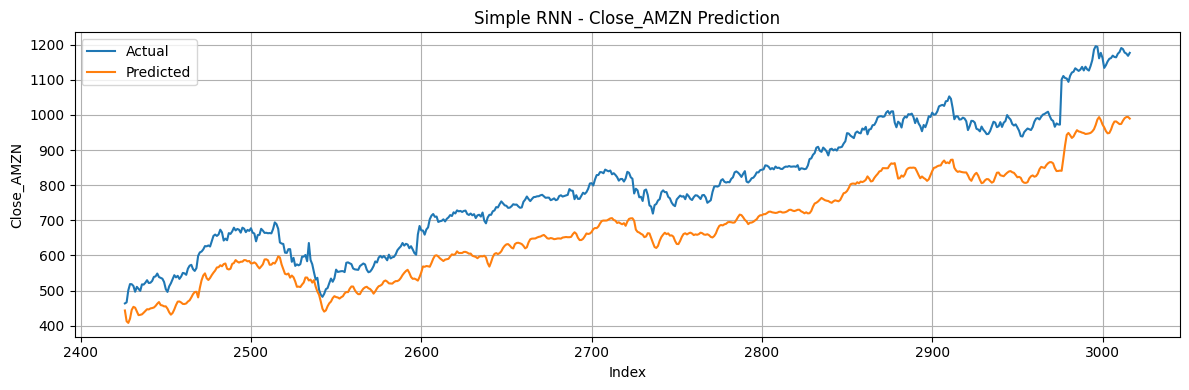

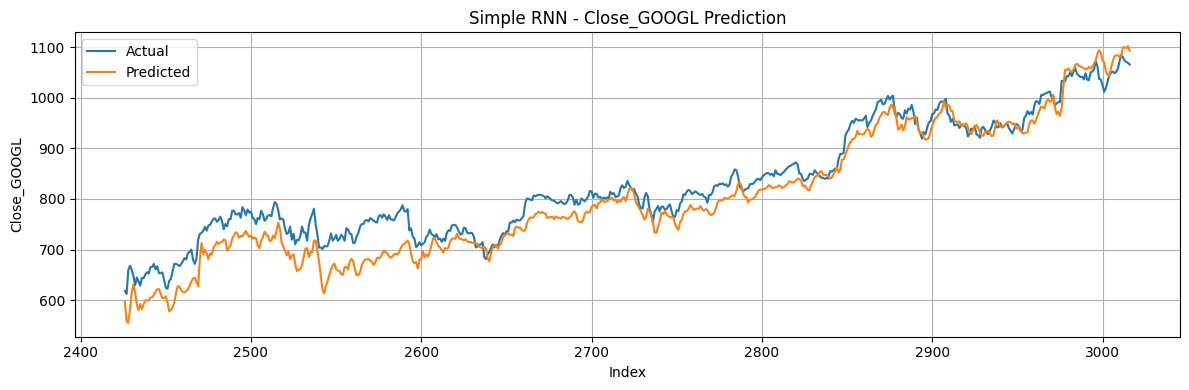

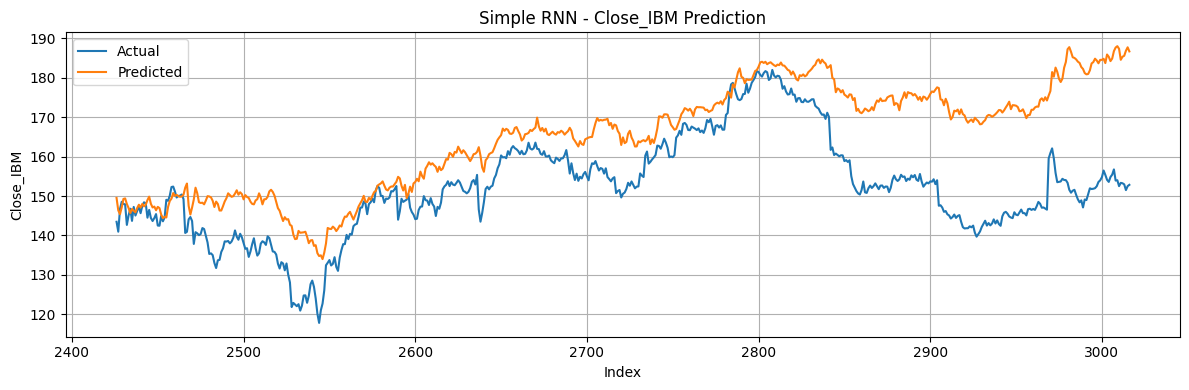

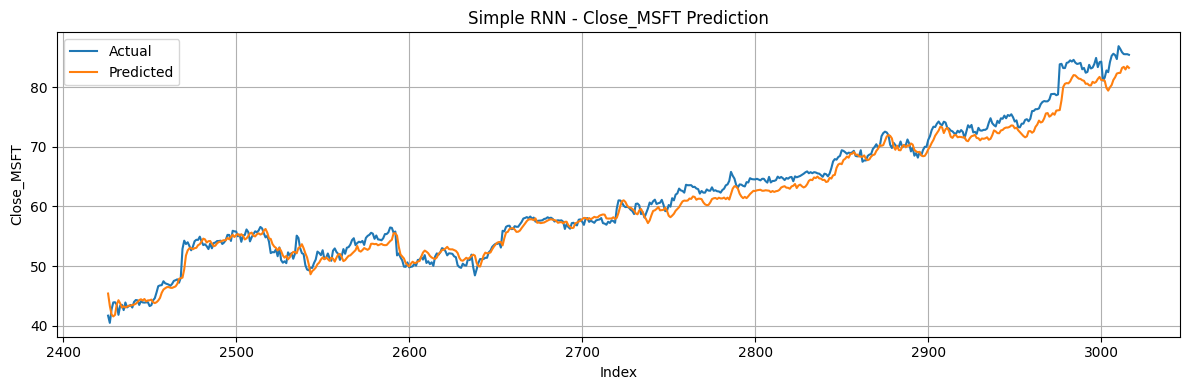


Simple RNN Model Evaluation Complete.


In [21]:
# Make predictions on the test data
y_pred_scaled_simple_rnn = simple_rnn_model.predict(X_test_scaled)



if 'y_scaler' not in locals() or 'y_test_scaled' not in locals():
    print("Error: 'y_scaler' or 'y_test_scaled' not found. Please run data preparation steps (1.1 - 1.3.5) first.")
    exit()

y_pred_simple_rnn = y_scaler.inverse_transform(y_pred_scaled_simple_rnn)
y_test_simple_rnn = y_scaler.inverse_transform(y_test_scaled)

# Evaluate the model performance
mse_simple_rnn = mean_squared_error(y_test_simple_rnn, y_pred_simple_rnn)
mae_simple_rnn = mean_absolute_error(y_test_simple_rnn, y_pred_simple_rnn)
r2_simple_rnn = r2_score(y_test_simple_rnn, y_pred_simple_rnn)

print(f"\n--- Simple RNN Model Performance on Test Data ---")
print(f"Mean Squared Error (MSE): {mse_simple_rnn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_simple_rnn:.4f}")
print(f"R-squared (R2) Score: {r2_simple_rnn:.4f}")

def plot_predictions(y_true, y_pred, dates, target_names, model_name="Model"):
    for i, name in enumerate(target_names):
        plt.figure(figsize=(12, 4))
        plt.plot(dates, y_true[:, i], label='Actual')
        plt.plot(dates, y_pred[:, i], label='Predicted')
        plt.title(f"{model_name} - {name} Prediction")
        plt.xlabel("Date" if not isinstance(dates[0], int) else "Index")
        plt.ylabel(name)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Plotting actual vs predicted values for all targets
print("\n--- Actual vs. Predicted Plots for Simple RNN Model ---")



if 'master_df' in locals() and 'window_size' in locals() and 'window_stride' in locals() and 'target_names' in locals() and 'test_split_ratio' in locals() and 'X_train_scaled' in locals():
    all_y_target_dates = []
    # Simulate the `create_windows` logic to get all relevant target dates
    # Ensure this loop matches the one used in create_windows exactly
    for i in range(0, len(master_df) - window_size - len(target_names) + 1, window_stride):
        if (i + window_size) < len(master_df):
            all_y_target_dates.append(master_df.index[i + window_size])
        else:
            break

    # Split these derived dates into train and test parts, matching the data split
    train_split_idx_for_dates = X_train_scaled.shape[0] # Number of training samples
    test_dates = all_y_target_dates[train_split_idx_for_dates:]

    if len(test_dates) != y_test_simple_rnn.shape[0]:
        print(f"Warning: Mismatch in length for test_dates ({len(test_dates)}) and Simple RNN test samples ({y_test_simple_rnn.shape[0]}). Plotting might be misaligned.")
        if len(test_dates) > y_test_simple_rnn.shape[0]:
            test_dates = test_dates[:y_test_simple_rnn.shape[0]]
        elif len(test_dates) < y_test_simple_rnn.shape[0]:
            print("Cannot auto-correct short test_dates for plotting. Please re-verify data splitting and date derivation.")
            # Fallback for plotting if dates cannot be matched robustly
            test_dates = range(y_test_simple_rnn.shape[0]) # Use numerical range if dates are problematic

    plot_predictions(y_test_simple_rnn, y_pred_simple_rnn, test_dates, target_names, model_name="Simple RNN")
else:
    print("Warning: Necessary variables for plotting (master_df, window_size, etc.) not found. Skipping detailed prediction plots.")

print("\nSimple RNN Model Evaluation Complete.")

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [22]:
# Compute the performance of the model on the testing data set

if (
    'y_test_simple_rnn' not in locals() or y_test_simple_rnn is None or
    'y_pred_simple_rnn' not in locals() or y_pred_simple_rnn is None
):
    print("Error: 'y_test_simple_rnn' or 'y_pred_simple_rnn' not found or is None.")
    exit()

# Flatten arrays if needed
y_test_flat = y_test_simple_rnn.ravel()
y_pred_flat = y_pred_simple_rnn.ravel()

# Evaluate the model performance
mse_simple_rnn = mean_squared_error(y_test_flat, y_pred_flat)
mae_simple_rnn = mean_absolute_error(y_test_flat, y_pred_flat)
r2_simple_rnn = r2_score(y_test_flat, y_pred_flat)

print(f"Mean Squared Error (MSE): {mse_simple_rnn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_simple_rnn:.4f}")
print(f"R-squared (R2) Score: {r2_simple_rnn:.4f}")
print("\nModel performance computation complete.")

Mean Squared Error (MSE): 4281.8677
Mean Absolute Error (MAE): 40.9047
R-squared (R2) Score: 0.9686

Model performance computation complete.


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [23]:
# Define a function to create a model and specify default values for hyperparameters

def create_lstm_model(input_shape, output_units, lstm_units=50, dense_units=25, dropout_rate=0.2, learning_rate=0.001):

    model = Sequential([

        LSTM(units=lstm_units, input_shape=input_shape, activation='relu', return_sequences=False),
        Dropout(dropout_rate),
        Dense(units=dense_units, activation='relu'),
        Dense(units=output_units)
    ])


    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae', 'mse'])

    return model

print("Function 'create_lstm_model' defined successfully with default hyperparameters.")

Function 'create_lstm_model' defined successfully with default hyperparameters.


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
def create_lstm_model(input_shape, output_units, lstm_units, dense_units, dropout_rate, learning_rate):

    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(output_units)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Define the grid of hyperparameters to search for LSTM
param_grid_lstm = {
    'lstm_units': [50, 75, 100, 125],
    'dense_units': [25, 50, 75],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001]
}

best_mae_lstm = float('inf')
best_params_lstm = {}
best_lstm_model = None
history_best_lstm_model = None



if 'X_train_scaled' in locals() and 'y_train_scaled' in locals():
    input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
    output_units = y_train_scaled.shape[1]
    print(f"Using input_shape: {input_shape} and output_units: {output_units} for tuning.")
else:
    print("Error: X_train_scaled or y_train_scaled not found. Please run data preparation steps (1.1 - 1.3.5) first.")


# Global training parameters
epochs = 100
batch_size = 32
patience_tuning = 20

# Initialize EarlyStopping callback for tuning
early_stopping_tuning_lstm = EarlyStopping(
    monitor='val_mae',
    patience=patience_tuning,
    restore_best_weights=True,
    verbose=0
)

trial_num_lstm = 0
total_trials_lstm = (len(param_grid_lstm['lstm_units']) * len(param_grid_lstm['dense_units']) *
                     len(param_grid_lstm['dropout_rate']) * len(param_grid_lstm['learning_rate']))

print(f"Starting LSTM hyperparameter search across {total_trials_lstm} combinations...")

for lstm_u in param_grid_lstm['lstm_units']:
    for dense_u in param_grid_lstm['dense_units']:
        for drop_r in param_grid_lstm['dropout_rate']:
            for lr in param_grid_lstm['learning_rate']:
                trial_num_lstm += 1
                print(f"\n--- LSTM Tuning Trial {trial_num_lstm}/{total_trials_lstm}: LSTM_Units={lstm_u}, Dense_Units={dense_u}, Dropout={drop_r}, LR={lr} ---")

                # Ensure X_train_scaled and y_train_scaled are defined before calling create_lstm_model
                if 'X_train_scaled' not in locals() or 'y_train_scaled' not in locals():
                    print("Skipping trial due to missing data. Please define X_train_scaled and y_train_scaled.")
                    continue # Skip to the next trial if data is not available

                model_candidate_lstm = create_lstm_model(
                    input_shape=input_shape,
                    output_units=output_units,
                    lstm_units=lstm_u,
                    dense_units=dense_u,
                    dropout_rate=drop_r,
                    learning_rate=lr
                )

                # Train the LSTM model
                history_candidate_lstm = model_candidate_lstm.fit(
                    X_train_scaled, y_train_scaled,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=[early_stopping_tuning_lstm],
                    verbose=0
                )

                # Get the best validation MAE from this trial
                current_val_mae_lstm = min(history_candidate_lstm.history['val_mae'])

                print(f"   Validation MAE for this LSTM configuration: {current_val_mae_lstm:.4f}")

                # Check if this is the best LSTM model so far
                if current_val_mae_lstm < best_mae_lstm:
                    best_mae_lstm = current_val_mae_lstm
                    best_params_lstm = {
                        'lstm_units': lstm_u,
                        'dense_units': dense_u,
                        'dropout_rate': drop_r,
                        'learning_rate': lr
                    }
                    best_lstm_model = model_candidate_lstm
                    history_best_lstm_model = history_candidate_lstm

print("\n--- LSTM Hyperparameter Tuning Complete ---")
print(f"Best Mean Absolute Error (MAE) found: {best_mae_lstm:.4f}")
print(f"Best LSTM Hyperparameters: {best_params_lstm}")

# --- Evaluate and Plot Best LSTM Model ---
if best_lstm_model:
    print("\n--- Evaluating Best Tuned LSTM Model on Test Data ---")
    y_pred_scaled_best_lstm = best_lstm_model.predict(X_test_scaled)

    # y_scaler and y_test_scaled must be defined from data prep
    if 'y_scaler' not in locals() or 'y_test_scaled' not in locals():
        print("Error: 'y_scaler' or 'y_test_scaled' not found for inverse transform. Please run data preparation steps (1.1 - 1.3.5) first.")
        # exit() # Uncomment if you want to stop execution here
    else:
        y_pred_best_lstm = y_scaler.inverse_transform(y_pred_scaled_best_lstm)
        y_test_unscaled_lstm = y_scaler.inverse_transform(y_test_scaled)

        mse_best_lstm = mean_squared_error(y_test_unscaled_lstm, y_pred_best_lstm)
        mae_best_lstm = mean_absolute_error(y_test_unscaled_lstm, y_pred_best_lstm)
        r2_best_lstm = r2_score(y_test_unscaled_lstm, y_pred_best_lstm)

        print(f"Best Tuned LSTM Model Performance (Test Data):")
        print(f"   Mean Squared Error (MSE): {mse_best_lstm:.4f}")
        print(f"   Mean Absolute Error (MAE): {mae_best_lstm:.4f}")
        print(f"   R-squared (R2) Score: {r2_best_lstm:.4f}")

        # Plot training history of the best LSTM model
        print("\n--- Training History of Best Tuned LSTM Model ---")
        history_dict_best_lstm = history_best_lstm_model.history
        loss_values_best_lstm = history_dict_best_lstm['loss']
        val_loss_values_best_lstm = history_dict_best_lstm['val_loss']
        mae_values_best_lstm = history_dict_best_lstm['mae']
        val_mae_values_best_lstm = history_dict_best_lstm['val_mae']
        epochs_range_best_lstm = range(len(loss_values_best_lstm))

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range_best_lstm, loss_values_best_lstm, label='Training Loss')
        plt.plot(epochs_range_best_lstm, val_loss_values_best_lstm, label='Validation Loss')
        plt.title('Training and Validation Loss (Best Tuned LSTM)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range_best_lstm, mae_values_best_lstm, label='Training MAE')
        plt.plot(epochs_range_best_lstm, val_mae_values_best_lstm, label='Validation MAE')
        plt.title('Training and Validation MAE (Best Tuned LSTM)')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("No best LSTM model found. This might indicate an issue with the tuning process")

Using input_shape: (65, 16) and output_units: 4 for tuning.
Starting LSTM hyperparameter search across 108 combinations...

--- LSTM Tuning Trial 1/108: LSTM_Units=50, Dense_Units=25, Dropout=0.1, LR=0.001 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   Validation MAE for this LSTM configuration: 0.1458

--- LSTM Tuning Trial 2/108: LSTM_Units=50, Dense_Units=25, Dropout=0.1, LR=0.0005 ---
   Validation MAE for this LSTM configuration: 0.0822

--- LSTM Tuning Trial 3/108: LSTM_Units=50, Dense_Units=25, Dropout=0.1, LR=0.0001 ---
   Validation MAE for this LSTM configuration: 1.7322

--- LSTM Tuning Trial 4/108: LSTM_Units=50, Dense_Units=25, Dropout=0.2, LR=0.001 ---
   Validation MAE for this LSTM configuration: 0.1166

--- LSTM Tuning Trial 5/108: LSTM_Units=50, Dense_Units=25, Dropout=0.2, LR=0.0005 ---
   Validation MAE for this LSTM configuration: 0.3026

--- LSTM Tuning Trial 6/108: LSTM_Units=50, Dense_Units=25, Dropout=0.2, LR=0.0001 ---
   Validation MAE for this LSTM configuration: 0.8818

--- LSTM Tuning Trial 7/108: LSTM_Units=50, Dense_Units=25, Dropout=0.3, LR=0.001 ---
   Validation MAE for this LSTM configuration: 0.0725

--- LSTM Tuning Trial 8/108: LSTM_Units=50, Dense_Units=25, Dropout=0.3, LR=0.0005 ---
   Valid

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Optimal LSTM Model Performance on Test Data ---
Mean Squared Error (MSE): 420.5620
Mean Absolute Error (MAE): 13.4621
R-squared (R2) Score: 0.9032

--- Training History of Optimal LSTM Model ---


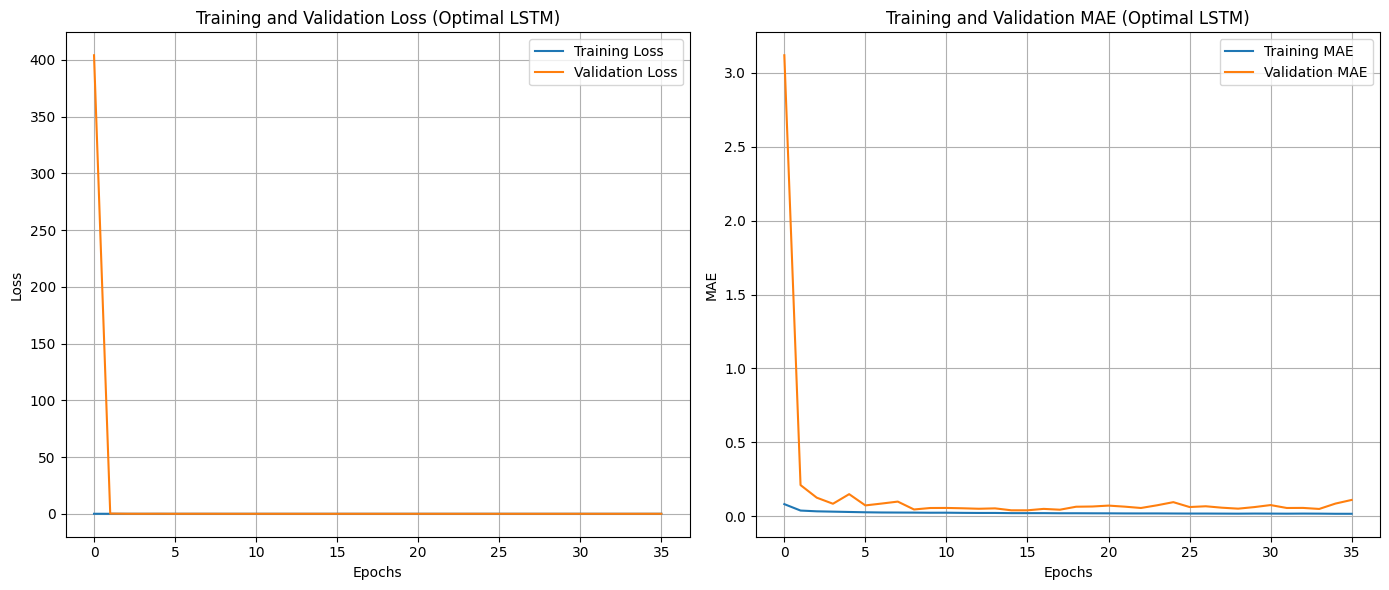

In [78]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
if 'best_lstm_model' not in locals() or 'history_best_lstm_model' not in locals():
    print("Error: 'best_lstm_model' or 'history_best_lstm_model' not found.")
    print("Please ensure Section 2.2.2 (LSTM Hyperparameter Tuning) has been run successfully.")
    exit() # Stop execution if prerequisites are not met

# Make predictions on the test data using the best model
y_pred_scaled_optimal_lstm = best_lstm_model.predict(X_test_scaled)

# Inverse transform the predictions and actuals to original scale
if 'y_scaler' not in locals() or 'y_test_scaled' not in locals():
    print("Error: 'y_scaler' or 'y_test_scaled' not found for inverse transform. Please run data preparation steps (1.1 - 1.3.5) first.")
    exit()

y_pred_optimal_lstm = y_scaler.inverse_transform(y_pred_scaled_optimal_lstm)
y_test_unscaled_optimal_lstm = y_scaler.inverse_transform(y_test_scaled)

# Evaluate the optimal model performance
mse_optimal_lstm = mean_squared_error(y_test_unscaled_optimal_lstm, y_pred_optimal_lstm)
mae_optimal_lstm = mean_absolute_error(y_test_unscaled_optimal_lstm, y_pred_optimal_lstm)
r2_optimal_lstm = r2_score(y_test_unscaled_optimal_lstm, y_pred_optimal_lstm)

print(f"\n--- Optimal LSTM Model Performance on Test Data ---")
print(f"Mean Squared Error (MSE): {mse_optimal_lstm:.4f}")
print(f"Mean Absolute Error (MAE): {mae_optimal_lstm:.4f}")
print(f"R-squared (R2) Score: {r2_optimal_lstm:.4f}")

# Plot training history of the optimal LSTM model
print("\n--- Training History of Optimal LSTM Model ---")
history_dict_optimal_lstm = history_best_lstm_model.history
loss_values_optimal_lstm = history_dict_optimal_lstm['loss']
val_loss_values_optimal_lstm = history_dict_optimal_lstm['val_loss']
mae_values_optimal_lstm = history_dict_optimal_lstm['mae']
val_mae_values_optimal_lstm = history_dict_optimal_lstm['val_mae']
epochs_range_optimal_lstm = range(len(loss_values_optimal_lstm))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_optimal_lstm, loss_values_optimal_lstm, label='Training Loss')
plt.plot(epochs_range_optimal_lstm, val_loss_values_optimal_lstm, label='Validation Loss')
plt.title('Training and Validation Loss (Optimal LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range_optimal_lstm, mae_values_optimal_lstm, label='Training MAE')
plt.plot(epochs_range_optimal_lstm, val_mae_values_optimal_lstm, label='Validation MAE')
plt.title('Training and Validation MAE (Optimal LSTM)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Plotting the actual vs predicted values


--- Actual vs. Predicted Plots for Optimal LSTM Model ---
Cannot auto-correct short test_dates for plotting. Please re-verify data splitting and date derivation.


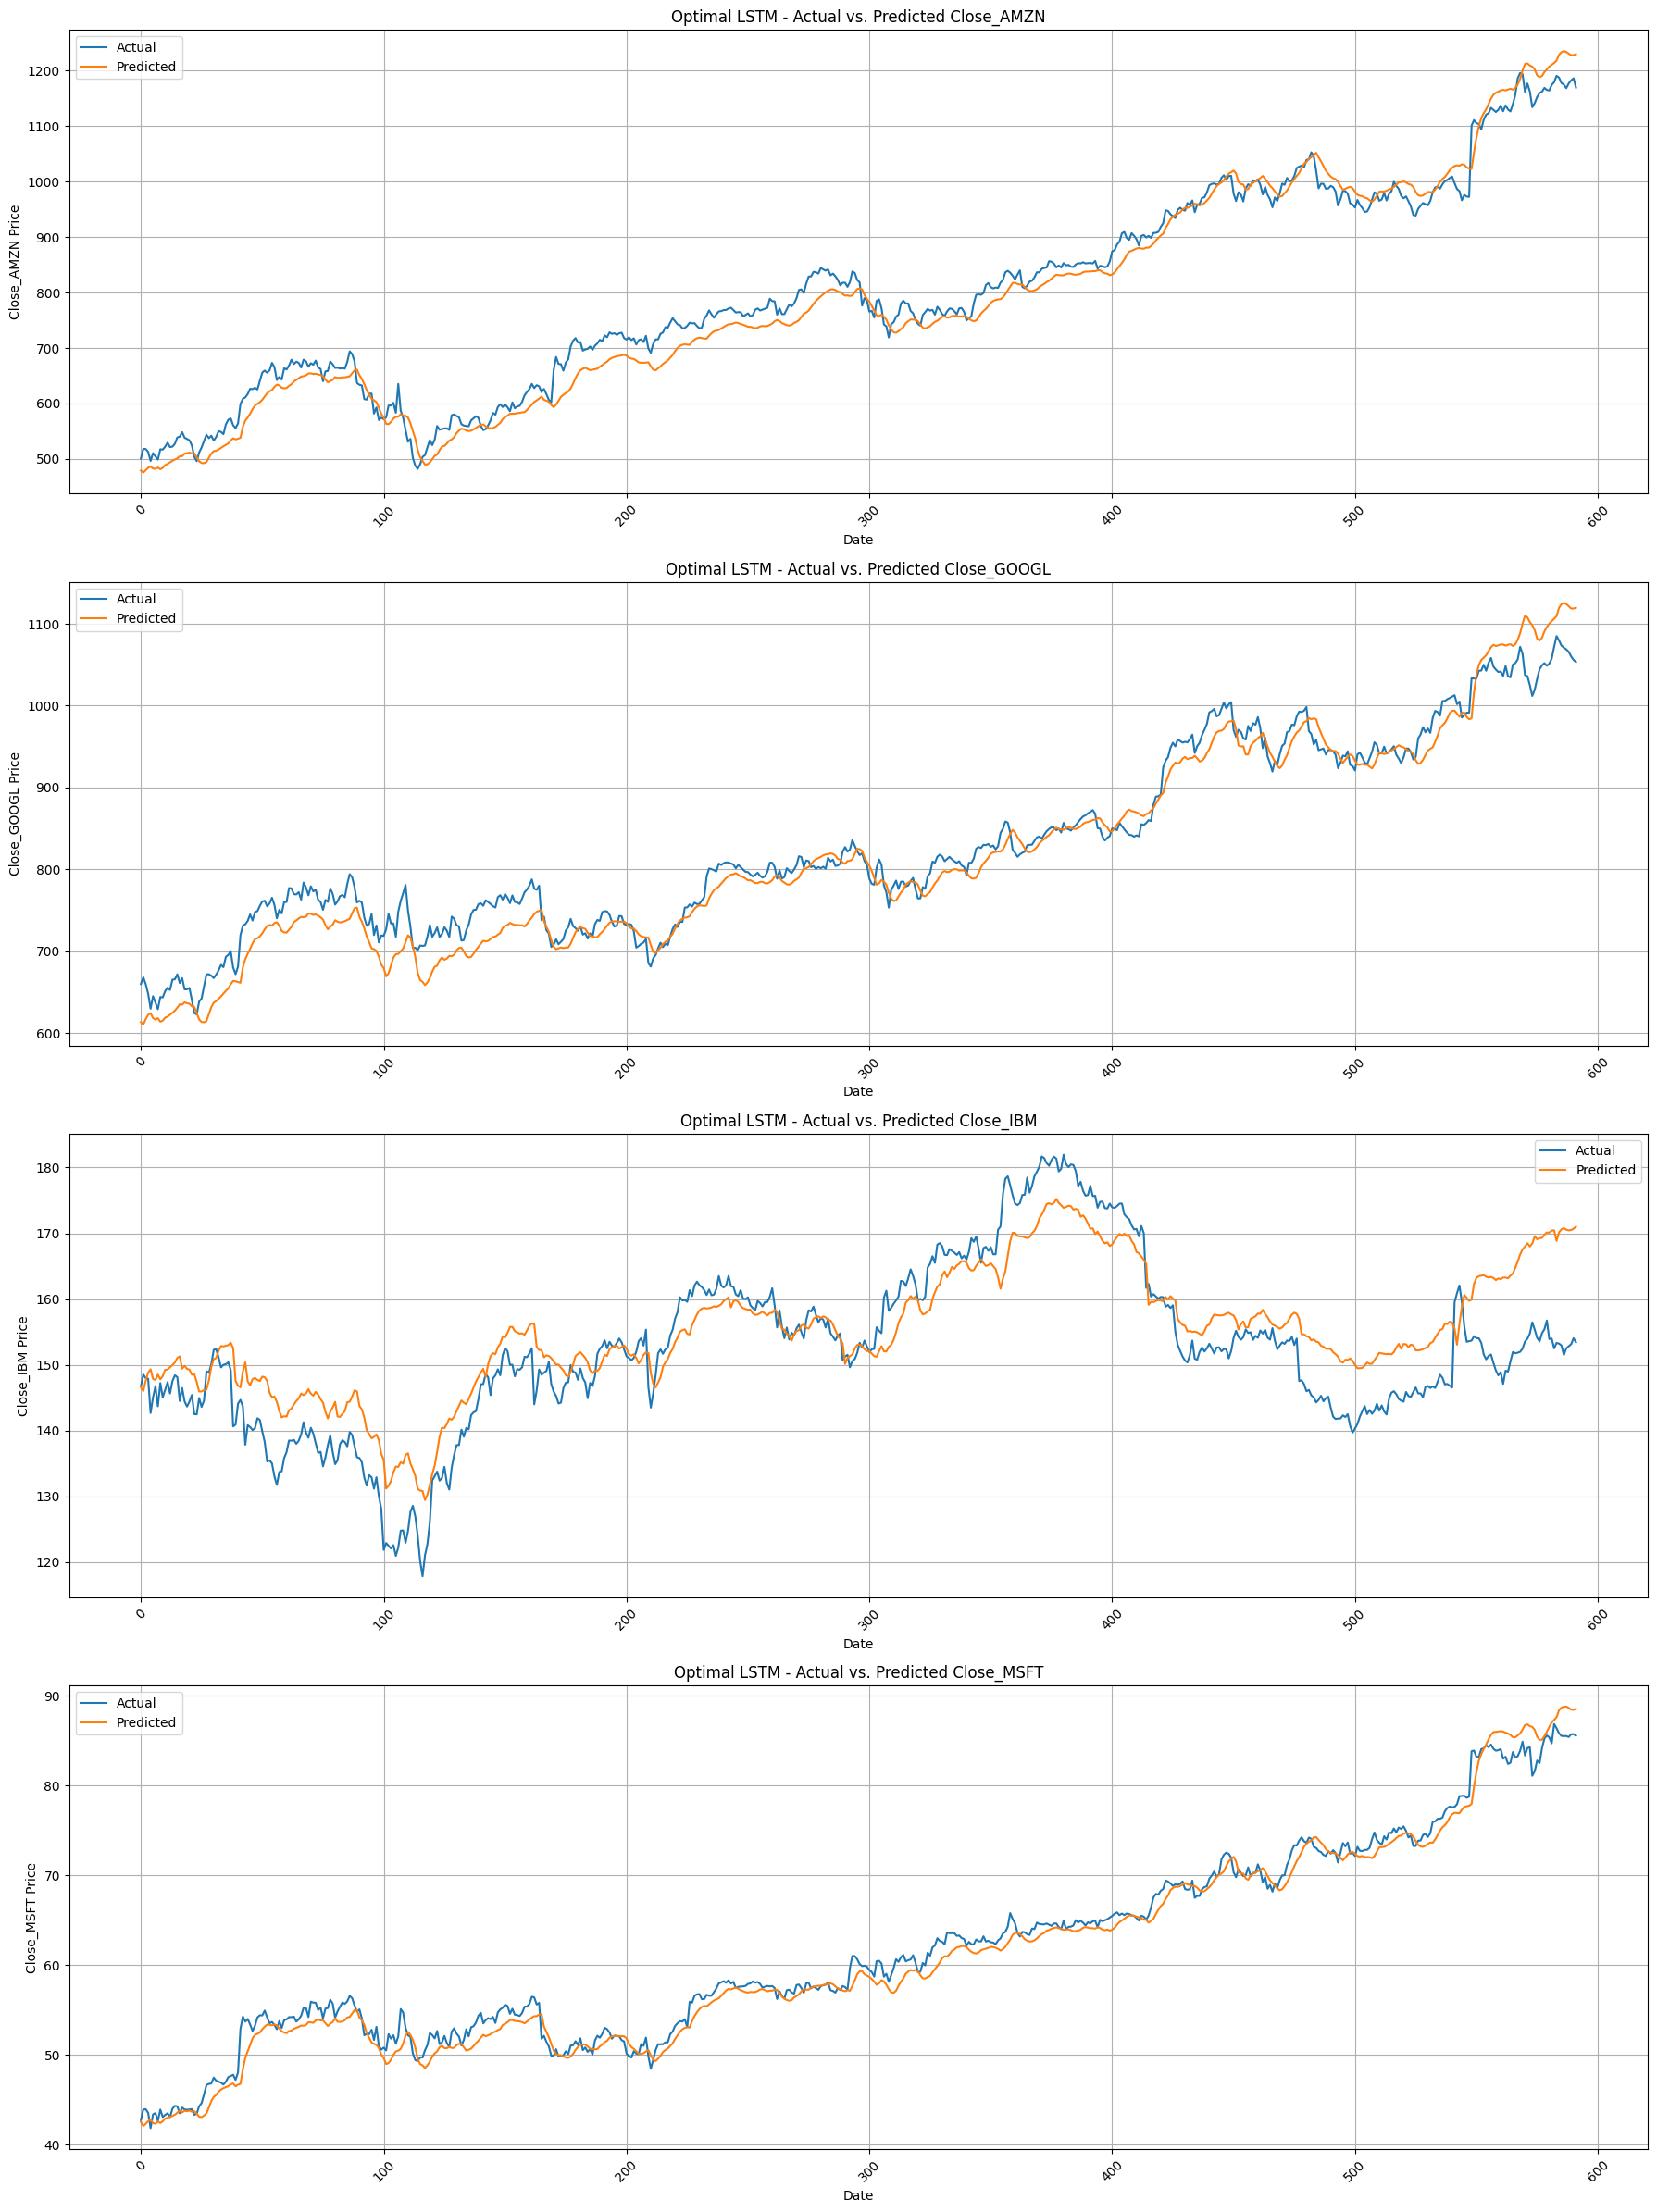


Optimal LSTM Model Performance Evaluation Complete.


In [77]:
# Predict on the test data
# Plot actual vs. predicted values for all targets
print("\n--- Actual vs. Predicted Plots for Optimal LSTM Model ---")

# Re-deriving `test_dates` to ensure consistency for plotting.

if 'master_df' in locals() and 'window_size' in locals() and 'window_stride' in locals() and 'target_names' in locals() and 'test_split_ratio' in locals() and 'X_train_scaled' in locals():
    all_y_target_dates = []
    for i in range(0, len(master_df) - window_size - len(target_names) + 1, window_stride):
        if (i + window_size) < len(master_df):
            all_y_target_dates.append(master_df.index[i + window_size])
        else:
            break

    train_split_idx_for_dates = X_train_scaled.shape[0]
    test_dates = all_y_target_dates[train_split_idx_for_dates:]

    if len(test_dates) != y_test_unscaled_optimal_lstm.shape[0]:
        print(f"Warning: Mismatch in length for test_dates ({len(test_dates)}) and optimal LSTM test samples ({y_test_unscaled_optimal_lstm.shape[0]}). Plotting might be misaligned.")
        if len(test_dates) > y_test_unscaled_optimal_lstm.shape[0]:
            test_dates = test_dates[:y_test_unscaled_optimal_lstm.shape[0]]
        elif len(test_dates) < y_test_unscaled_optimal_lstm.shape[0]:
            print("Cannot auto-correct short test_dates for plotting. Please re-verify data splitting and date derivation.")
            test_dates = range(y_test_unscaled_optimal_lstm.shape[0]) # Fallback for plotting

    plot_predictions(y_test_unscaled_optimal_lstm, y_pred_optimal_lstm, test_dates, target_names, model_name="Optimal LSTM")
else:
    print("Warning: Necessary variables for plotting (master_df, window_size, etc.) not found. Skipping detailed prediction plots.")

print("\nOptimal LSTM Model Performance Evaluation Complete.")


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

-> Recurrent Neural Networks (RNNs), particularly LSTMs and GRUs, are well-suited for time series prediction tasks like stock price forecasting due to their ability to learn from sequential data.

-> Hyperparameter tuning is crucial for optimizing model performance. The chosen metrics (MSE, RMSE, R2) provide quantitative measures of model accuracy.
-> Predicting multiple target variables with a single model is feasible and can capture inter-stock relationships, potentially offering a more holistic view of market sentiment.

-> The model's performance can be further improved by incorporating more features (e.g., economic indicators, news sentiment), using more complex architectures, or employing ensemble methods.

-> It's important to note that stock price prediction is inherently challenging due to market volatility and external factors. While these models can identify patterns, they don't guarantee future profits and should be used with caution.